# MCT4052 Workshop 5b: Audio Files + PCA + SVM Classifier

*Author: Stefano Fasciani, stefano.fasciani@imv.uio.no, Department of Musicology, University of Oslo.*

The notebooks Workshop 5b to 5h integrates a stage of dimensionality reduction with different type of machine learning technique (classification, regression, clustering) on audio or MIDI data. The machine learning techniques included in this set of examples are those from previous workshops.

In [1]:
import numpy as np
import pandas as pd
import scipy
import librosa, librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as ms
#ms.use("seaborn-v0_8")
import IPython.display as Ipd
import os
import sklearn

%matplotlib inline
%config IPCompleter.greedy=True

In [2]:
#loading the metadata in a pandas data structure and displaying
metadata = pd.read_csv('./data/examples4/meta.csv')

In [3]:
#finding unique labels (i.e. how many different classes in the dataset)
classes = list(metadata.label.unique()) # finding unique elements in the 'label' column
print('There are',len(classes),'different classes:',classes)

There are 5 different classes: ['cello', 'guitar', 'clarinet', 'flute', 'harmonica']


In [4]:
sr = 22050

def extract_features(filename, sr):
    
    signal, dummy = librosa.load(filename, sr=sr, mono=True)
    
    output = [
        np.mean(librosa.feature.zero_crossing_rate(y=signal)),
        np.mean(librosa.feature.spectral_centroid(y=signal)),
        np.mean(librosa.feature.spectral_contrast(y=signal)), 
        np.mean(librosa.feature.spectral_flatness(y=signal)),
        np.mean(librosa.feature.spectral_bandwidth(y=signal)),
        np.mean(librosa.feature.spectral_rolloff(y=signal)),
        np.mean(librosa.feature.rms(y=signal))
    ]
    
    return output


num_of_features = len(extract_features('./data/examples4/'+metadata['filename'][0], sr))
features = np.zeros((len(metadata.index),num_of_features)) 
labels = np.zeros((len(metadata.index))) 
filenames = []

for i, row in metadata.iterrows():
    features[i,:] = extract_features('./data/examples4/'+row['filename'], sr)
    filenames.append('./data/examples4/'+row['filename'])
    labels[i] = (classes.index(row['label']))

print('Done!')

Done!


In [5]:
#this step converts the labels from a numpy array to 
#a Pandas series, which allows backtracing misclassified examples
#scikitlearn can handle features or labels also as Pandas formats
labels = pd.Series(labels)

In [6]:
from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
feat_train, feat_test, lab_train, lab_test = train_test_split(features, labels, test_size=0.2, random_state=77)

In [7]:
from sklearn.preprocessing import StandardScaler

#learning the scaling transformation from the train data and applying it to both train and test set.

#creating scaling object
scaler = StandardScaler()

#learning scaling from train set
scaler.fit(feat_train)

#applying scaling to both train and test set
feat_train = scaler.transform(feat_train)
feat_test = scaler.transform(feat_test)

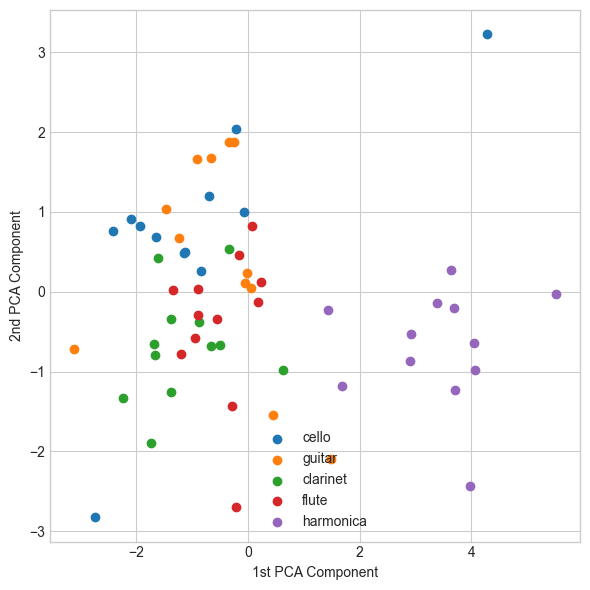

In [8]:
from sklearn.decomposition import PCA

#Creating an instance of a PCA object, which is an object capable of learning and applying PCA from/to data.
#We instruct the PCA to keep only N components
pca = PCA()

#This will learn PCA projection from train data
pca.fit(feat_train)

#Now we project the data
projected_features_train = pca.transform(feat_train)
projected_features_test = pca.transform(feat_test)

#this is only for scatter plot purposes
projected_features = pca.transform(scaler.transform(features))

#Plot the distribution of the data according to the first two principle components
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 6))
    for lab_val, lab_name in zip(range(0,len(classes)),classes):
        plt.scatter(projected_features[labels==lab_val, 0],
                    projected_features[labels==lab_val, 1],
                    label=lab_name)
    plt.xlabel('1st PCA Component')
    plt.ylabel('2nd PCA Component')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

In [9]:
# keeping a lower number of dimensions
num_of_dim95 = np.min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.95)) + 1

print(num_of_dim95)

# dimension before
print(projected_features_train.shape)
print(projected_features_test.shape)

# keeping only a number of components (columns, or features) carryinng 95% of total variance
projected_features_train = projected_features_train[:,0:num_of_dim95]
projected_features_test = projected_features_test[:,0:num_of_dim95]


# dimension after
print(projected_features_train.shape)
print(projected_features_test.shape)

4
(48, 7)
(12, 7)
(48, 4)
(12, 4)


In [10]:
#Creating an instance of a SVN classifier
#and setting it to use a linear kernel
model_SVN = sklearn.svm.SVC(kernel='linear', C=1.0)

#training the model
model_SVN.fit(projected_features_train, lab_train)

#applying the the model on the test data
lab_predict = model_SVN.predict(projected_features_test)


#print the number of misclassified samples, accuracy, complete report, and confusion matrix
print('Number of mislabeled samples %d out of %d' % ((lab_test != lab_predict).sum(),lab_test.size))
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))
print(sklearn.metrics.classification_report(lab_test, lab_predict))
print(sklearn.metrics.confusion_matrix(lab_test, lab_predict))

Number of mislabeled samples 3 out of 12
Accuracy: 0.75
              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50         1
         1.0       0.00      0.00      0.00         1
         2.0       1.00      0.67      0.80         3
         3.0       1.00      0.75      0.86         4
         4.0       1.00      1.00      1.00         3

    accuracy                           0.75        12
   macro avg       0.67      0.68      0.63        12
weighted avg       0.86      0.75      0.78        12

[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 2 0 0]
 [0 1 0 3 0]
 [0 0 0 0 3]]


In [11]:
#displaying names of misclassified files
results = lab_test == lab_predict
for index, value in results.items():
    if value == False:
        print(filenames[index])


./data/examples4/c08227e9.wav
./data/examples4/74cfa1eb.wav
./data/examples4/75916a91.wav
